# Neural style transfer

paper
[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)


In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## Visualize the input

In [5]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    print(shape)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    print(new_shape)
    img = tf.image.resize(img, new_shape)
    print(img[1][1])
    img = img[tf.newaxis, :]
    return img

In [6]:
content_image = load_img(content_path)

tf.Tensor([577. 700.], shape=(2,), dtype=float32)
tf.Tensor([422 512], shape=(2,), dtype=int32)
tf.Tensor([0.60180223 0.62551117 0.3700369 ], shape=(3,), dtype=float32)


In [7]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

tf.Tensor([ 657. 1000.], shape=(2,), dtype=float32)
tf.Tensor([336 512], shape=(2,), dtype=int32)
tf.Tensor([0.8418939  0.60784537 0.44832402], shape=(3,), dtype=float32)


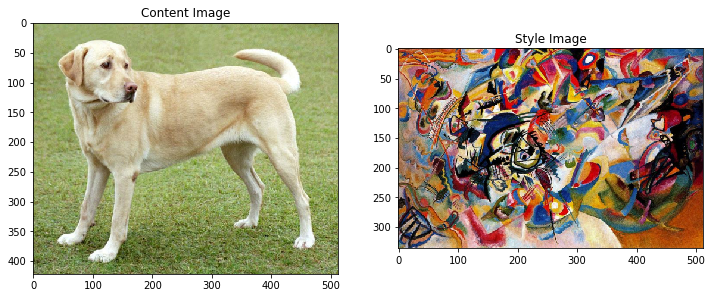

In [8]:
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

TensorFlow Hub : 재사용 가능한 머신러닝 모듈 라이브러리


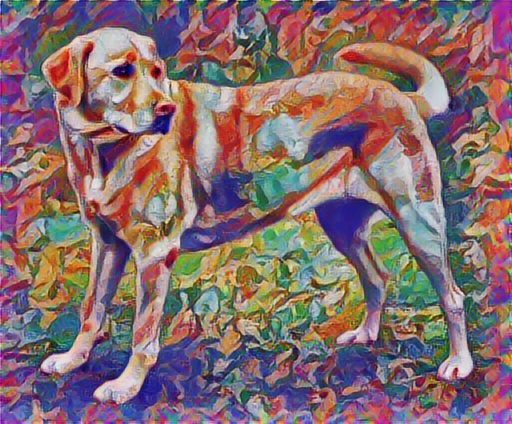

In [23]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

- the first few layer activations represent low-level features like edges and textures. 

- the final few layers represent higher-level features—object parts like wheels or eyes.

`VGG19` network architecture : a pretrained image classification network

색을 표현하는 방법 255 > White	#FFFFFF	(255,255,255)

In [29]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)

In [31]:
x.shape

TensorShape([1, 422, 512, 3])

In [34]:
x.get_shape

<bound method _EagerTensorBase.get_shape of <tf.Tensor: id=8385, shape=(1, 422, 512, 3), dtype=float32, numpy=
array([[[[ -4.524124 ,  48.63587  ,  36.73487  ],
         [-10.10482  ,  41.95362  ,  29.501839 ],
         [-11.571709 ,  39.58831  ,  26.68731  ],
         ...,
         [-20.554573 ,  25.605446 ,  10.704445 ],
         [-28.120094 ,  18.489143 ,   3.5881348],
         [-33.619164 ,  13.540855 ,  -1.3601532]],

        [[ -9.83992  ,  43.871025 ,  30.868141 ],
         [ -9.57959  ,  42.72634  ,  29.779564 ],
         [ -8.837097 ,  42.3229   ,  29.421898 ],
         ...,
         [-21.978981 ,  24.731972 ,   9.830971 ],
         [-20.947105 ,  25.965569 ,  11.064568 ],
         [-20.448227 ,  26.71177  ,  11.810768 ]],

        [[-16.009468 ,  38.150536 ,  24.24955  ],
         [-10.524132 ,  41.98353  ,  28.633308 ],
         [ -7.0960693,  44.906853 ,  29.477089 ],
         ...,
         [-20.78109  ,  26.378914 ,  11.477913 ],
         [-15.424103 ,  31.735893 ,  16.834

In [35]:
x = tf.image.resize(x, (224, 224))
x.get_shape

<bound method _EagerTensorBase.get_shape of <tf.Tensor: id=8387, shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[ -8.801555  ,  43.80758   ,  31.23794   ],
         [ -3.3201537 ,  46.91127   ,  30.959774  ],
         [ 10.250625  ,  59.694942  ,  40.16895   ],
         ...,
         [-23.171505  ,  21.363684  ,   6.462689  ],
         [-21.019142  ,  25.158255  ,  10.257255  ],
         [-25.967201  ,  20.924969  ,   6.023963  ]],

        [[-13.0738945 ,  39.718273  ,  25.404175  ],
         [ -4.788845  ,  46.259747  ,  29.90681   ],
         [  8.037533  ,  58.967346  ,  39.52311   ],
         ...,
         [-14.135152  ,  32.041187  ,  16.4884    ],
         [-18.09348   ,  28.766468  ,  13.213692  ],
         [-13.957483  ,  33.94943   ,  18.396646  ]],

        [[-15.827937  ,  35.42919   ,  19.00702   ],
         [-11.070037  ,  42.070057  ,  24.204107  ],
         [ -2.1710446 ,  50.595463  ,  31.00231   ],
         ...,
         [-10.3856945 ,  37.33857   ,  20.429115

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

490979328/574710816 [========================>.....] - ETA: 12:11

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

### Choose intermediate

In [9]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [10]:
num_content_layers, num_style_layers

(1, 5)

somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model

you can easily extract the intermediate layer values using the Keras functional API


In [11]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [12]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

80142336/80134624 [==============================] - 1s 0us/step

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.525628056965
  mean:  33.97524237819644

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.885701259586
  mean:  199.82682098802692

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24004687194
  mean:  230.78098570100678

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.13386932198
  mean:  791.2399405777323

block5_conv1
  

## Calculate style

Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations.

In [22]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float64)
    return result/(num_locations)

## Extract style and content

return the style and content tensors.

In [23]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
    
#         for style_output in style_outputs:
#             print(style_output)
#             gram_matrix(style_output)

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [24]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522844430225139
    max:  28014.563703864776
    mean:  263.79023022671316

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.49178519945
    mean:  9100.94963310253

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.3597001235
    mean:  7660.97643435956

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.2518730555
    mean:  134288.8646581274

   block5_conv1
    shape:  